### Ajuste de curvas. Datos COVID19

#### Fuente de datos: https://coronavirus.gob.mx/datos/

Antes de comenzar se aclara que los siguientes análisis son únicamente ilustrativos para la clase de Métodos Numéricos. Las estimaciones y/o conclusiones que se obtengan de ninguna manera se deberán interpretar como ciertas ni deben ser un respaldo para toma de decisiones.
#### Insistimos. Esto es sólo simulacro y se está omitiendo toda la metodología que un verdadero análisis de datos necesita.

Iniciando el ejercicio. Obtención de datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get all data from csv file as dataframe
CovidMX_data_file = 'Casos_Diarios_Estado_Nacional_Confirmados_20200517.csv'
df = pd.read_csv(CovidMX_data_file, index_col = 0, parse_dates=[0])
print(df.head(5)) # Print an overview of full data

# Get only national data. Exclude the information by state.
df_Nacional = df.loc[df.index[df['nombre'] == 'Nacional'].tolist()]

         poblacion               nombre  07-01-2020  08-01-2020  09-01-2020  \
cve_ent                                                                       
1          1434635       AGUASCALIENTES           0           0           0   
2          3634868      BAJA CALIFORNIA           0           0           0   
3           804708  BAJA CALIFORNIA SUR           0           0           0   
4          1000617             CAMPECHE           0           0           0   
7          5730367              CHIAPAS           0           0           0   

         10-01-2020  11-01-2020  12-01-2020  13-01-2020  14-01-2020  ...  \
cve_ent                                                              ...   
1                 0           0           0           0           1  ...   
2                 0           0           0           0           0  ...   
3                 0           0           0           0           0  ...   
4                 0           0           0           0           

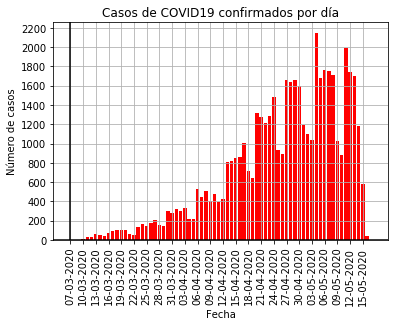

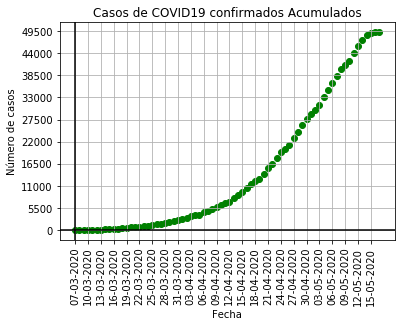

In [2]:
# Get the dates as a list
list_of_dates = list(df_Nacional.columns)[62:] # Start list at 06-03-2020

# Creation of list for confirmed cases by day
confirmed_by_day = []
for date_ in list_of_dates:
    confirmed_by_day.append(df_Nacional[date_][0])

# Creation of list for accumulated cases
accumulated_cases = [0]
for date_ in list_of_dates:
    accumulated_cases.append(accumulated_cases[-1] + df_Nacional[date_][0])
del accumulated_cases[0] # Remove the first element

# Data visualization
plt.bar(list_of_dates, confirmed_by_day, color = 'r')
plt.title('Casos de COVID19 confirmados por día')
plt.xlabel('Fecha')
plt.ylabel('Número de casos')
plt.xticks(list_of_dates[0::3], rotation = 90)
plt.yticks(np.arange(0, 2400, 200))
plt.grid()
plt.axvline(color = 'k')
plt.axhline(color = 'k')
plt.show()

plt.scatter(list_of_dates, accumulated_cases, color = 'g')
plt.title('Casos de COVID19 confirmados Acumulados')
plt.xlabel('Fecha')
plt.ylabel('Número de casos')
plt.xticks(list_of_dates[0::3], rotation = 90)
plt.yticks(np.arange(0, 55000, 5500))
plt.grid()
plt.axvline(color = 'k')
plt.axhline(color = 'k')
plt.show()

Vemos que en los útimos tres días la información no es muy confiable debido a retrasos en la distribución de los datos y otros factores. Se omitirán los datos de los tres últimos días.

In [3]:
list_of_dates = list_of_dates[:-3]
confirmed_by_day = confirmed_by_day[:-3]
accumulated_cases = accumulated_cases[:-3]

### Ajuste de curva. Casos confirmados acumulados

Es evidente que una regresión no nos servirá en este caso ya que la tendencia de los datos sigue un crecimiento cercano la ecuación de potencias

$$y = \alpha_1 x^{\beta_1}$$

Existen técnicas de regresión no lineal para ajustar ecuaciones a datos experimentales. En este caso nos iremos por otro camino. Nos auxiliaremos de la "linealización" de los datos.

Para linealizar la ecuación mostrada anteriormente basta con aplicar logaritmo natural a toda la ecuación

$$ln(y) = \beta_1 ln(x) + ln(\alpha_1)$$

La última ecuación tiene gran similitud con la ecuación de la recta ($y = mx + b$). Si nosotros hacemos una gráfica de $ln(y)$ vs $ln(x)$ nos dará una línea recta con pendiente $\beta_1$ y una intersección con el eje de las ordenadas igual a $ln(\alpha_1)$

Para el caso de casos confirmados acumulados:
* y = Número de casos
* x = Fecha

Es necesario convertir nuestros datos de fecha a datos que puedan ser operables matemáticamente (no se puede obtener logaritmo del 12 de marzo del 2020). Simplemente cada fecha representará un índice en una cuenta comenzando desde el 1 hasta donde terminen las fechas disponibles de nuestros datos.

#### Graficando $ln(y)$ vs $ln(x)$ [$ln(Número de casos)$ vs $ln(fecha)$]

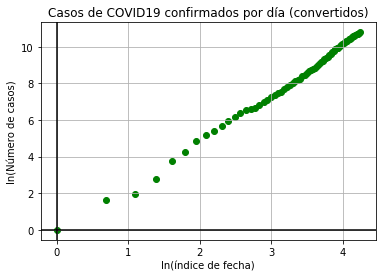

In [4]:
# Date data convertion
dates_converted = []
for i in range(len(list_of_dates)):
    dates_converted.append(i + 1)
    
# Data visualization
plt.scatter(np.log(dates_converted), np.log(accumulated_cases), color = 'g')
plt.title('Casos de COVID19 confirmados por día (convertidos)')
plt.xlabel('ln(índice de fecha)')
plt.ylabel('ln(Número de casos)')
plt.grid()
plt.axvline(color = 'k')
plt.axhline(color = 'k')
plt.show()

Ahora, con los datos convertidos, es innegable la tendencia lineal de los datos.

El siguiente paso será aplicar lo visto en la clase de regresión lineal, es decir

$$\beta_1 = \frac{n \sum ln(x_i)ln(y_i) - \sum ln(x_i) \sum ln(y_i)}{n \sum ln(x_i)^2 - \left( \sum ln(x_i) \right)^2}$$

$$\alpha_1 = \overline{ln(y_i)} - \beta_1 \overline{ln(x_i)}$$

In [5]:
n = len(accumulated_cases)

# Convert list into arrays to operate
a_dates_converted = np.asarray(dates_converted)
a_accumulated_cases = np.asarray(accumulated_cases)

beta_1 = (n*np.sum(np.log(a_dates_converted)*np.log(a_accumulated_cases)) - np.sum(np.log(a_dates_converted))*np.sum(np.log(a_accumulated_cases)))/(n*np.sum(np.log(a_dates_converted)*np.log(a_dates_converted)) - (np.sum(np.log(a_dates_converted)))**2)
alpha_1 = np.mean(np.log(a_accumulated_cases)) - beta_1*np.mean(np.log(a_dates_converted)) 

print("alpha_1 = {:.6}".format(alpha_1), \
      "\nbeta_1 = {:.6}".format(beta_1))

def linear_model(alpha_1, beta_1, x_input):
    return(beta_1*x_input + alpha_1)

r = (n*np.sum(np.log(a_dates_converted)*np.log(a_accumulated_cases)) - np.sum(np.log(a_dates_converted))*np.sum(np.log(a_accumulated_cases)))/(np.sqrt(n*np.sum(np.log(a_dates_converted)*np.log(a_dates_converted)) - (np.sum(np.log(a_dates_converted)))**2) * np.sqrt(n*np.sum(np.log(a_accumulated_cases)*np.log(a_accumulated_cases)) - (np.sum(np.log(a_accumulated_cases)))**2))

print("\nr = {:.6}".format(r))

alpha_1 = -0.535491 
beta_1 = 2.64904

r = 0.997654


Obteniendo como resultado la siguiente recta

$$ln(y) = 2.64904 ln(x) - 0.535491$$

Para comprobar nuestro resultado es necesario graficar.

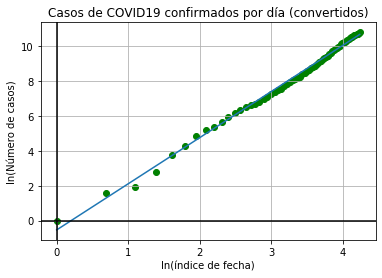

In [6]:
# Data visualization
plt.scatter(np.log(dates_converted), np.log(accumulated_cases), color = 'g')
plt.plot([np.log(dates_converted)[0], np.log(dates_converted)[-1]], \
         [linear_model(alpha_1, beta_1, np.log(dates_converted)[0]), linear_model(alpha_1, beta_1, np.log(dates_converted)[-1])])
plt.title('Casos de COVID19 confirmados por día (convertidos)')
plt.xlabel('ln(índice de fecha)')
plt.ylabel('ln(Número de casos)')
plt.grid()
plt.axvline(color = 'k')
plt.axhline(color = 'k')
plt.show()

De forma gráfica y con soporte en el parámetro $r$ podemos asegurar que nuestro modelo es suficientemente certero.

Ahora, todo este tiempo nos estuvimos manejando en el dominio de los logaritmos, es necesario regresar al dominio de los datos iniciales.

Es posible observar que $\beta_1$ no se verá afectado, sin embargo el término independiente de nuestra recta es $ln(\alpha_1)$ por lo que necesita una transformación para dejarlo únicamente como $\alpha_1$

$$ln(\alpha_1) = - 0.535491$$

$$\alpha_1 = e^{- 0.535491} = 0.58538$$

#### Sustituyendo en el modelo inicial

Recordemos que nuestro modelo propuesto fue

$$y = \alpha_1 x^{\beta_1}$$

Sustituyendo los datos nos quedará

$$y = 0.58538 x^{2.64904}$$

#### Comprobando

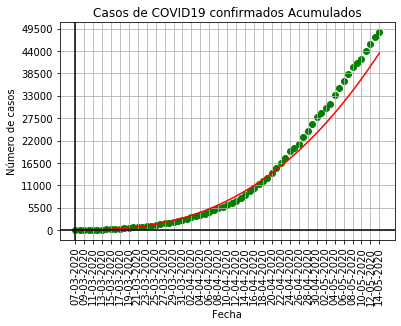

In [7]:
alpha_1_converted = np.e**(alpha_1)

def pow_model(alpha_1_converted, beta_1, x_input):
    return(alpha_1_converted*(x_input**(beta_1)))

our_model = []
for i in range(n):
    our_model.append(pow_model(alpha_1_converted, beta_1, dates_converted[i]))

# Data visualization
plt.scatter(list_of_dates, accumulated_cases, color = 'g')
plt.plot(list_of_dates, our_model, color = 'r')
plt.title('Casos de COVID19 confirmados Acumulados')
plt.xlabel('Fecha')
plt.ylabel('Número de casos')
plt.xticks(list_of_dates[0::2], rotation = 90)
plt.yticks(np.arange(0, 55000, 5500))
plt.grid()
plt.axvline(color = 'k')
plt.axhline(color = 'k')
plt.show()

### Ajuste de curva. Casos por día

Para este caso vamos a suponer una distribución normal (distribución Gaussiana) de los datos 

$$f(x) = \frac{A}{\sigma \sqrt{2 \pi}} e^{- \frac{1}{2} \left( \frac{x - \mu}{ \sigma } \right)^2}$$

Los datos a estimar son:

* $ \mu = $ Media de los datos
* $ \sigma = $ Desviación estandar de los datos
* $ A = $ Escalamiento de la curva

Estos parámetros fueron estimados a prueba y error.

#### Gráfica de los datos

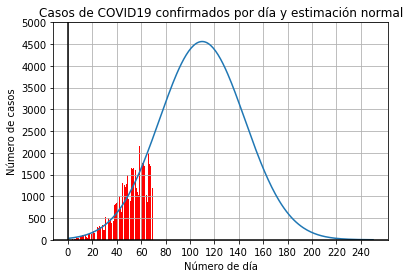

In [8]:
#******************************************************************************
# Convert into a list
confirmed_by_day = np.asarray(confirmed_by_day)

x_for_data = np.arange(1, len(list_of_dates) + 1)
#******************************************************************************

x = np.arange(1, 251)

mu = 110
std = 35
scale = 4e5

def normal_distribution(mu, std, x_in):
    return (scale/(std*np.sqrt(2*np.pi))*np.e**(-1/2*((x_in - mu)/std)**2))

distribution = []
for i in range(len(x)):
    distribution.append(normal_distribution(mu, std, x[i]))

plt.plot(x, distribution)
plt.bar(x_for_data, confirmed_by_day, color = 'r')
plt.title('Casos de COVID19 confirmados por día y estimación normal')
plt.xlabel('Número de día')
plt.ylabel('Número de casos')
plt.xticks(np.arange(0, 260, 20))
plt.yticks(np.arange(0, 5500, 500))
plt.grid()
plt.axvline(color = 'k')
plt.axhline(color = 'k')
plt.show()